In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import yaml



2023-12-11 16:59:35.560057: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 16:59:35.748215: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 16:59:35.748270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 16:59:35.773446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 16:59:35.831809: I tensorflow/core/platform/cpu_feature_guar

In [2]:
np.random.seed(42)

# Set the path to the dataset
dataset_path = '.'

# Set the paths to images and annotations
images_folder = os.path.join(dataset_path, 'Images')
annotations_folder = os.path.join(dataset_path, 'Bounding_Boxes')

# Model configuration
input_shape = (512, 512, 3)  # Adjust based on your image size

In [3]:
class BoundingBox:
    def __init__(self, xmin, ymin, xmax, ymax, class_id, img_path):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.class_id = class_id
        self.img_path = img_path

    def __repr__(self):
        return f'[{self.xmin}, {self.ymin}, {self.xmax}, {self.ymax} | {self.class_id}]'


In [4]:
# Data preprocessing and loading
def load_data():
    images = []
    annotations = []
    label_map = {}

    # Open Bounding_Boxes/darknet.labels and read class names and put into label_map
    with open(os.path.join(annotations_folder, 'darknet.labels'), 'r') as f:
        class_names = f.readlines()
        for i, class_name in enumerate(class_names):
            label_map[i] = class_name.strip()

    # return images, labels
    for annotation_name in os.listdir(annotations_folder):

        # If no .txt files, continue
        if not annotation_name.endswith('.txt'):
            continue

        # Load image
        image_name = annotation_name.replace('.txt', '.jpg')
        image_path = os.path.join(images_folder, image_name)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_image_width, original_image_height = image.shape[1], image.shape[0]
        image = cv2.resize(image, (input_shape[0], input_shape[1]))

        images.append(image)

        # Load annotations
        annotation_path = os.path.join(annotations_folder, annotation_name)
        with open(annotation_path, 'r') as f:
            # Parse bounding box coordinates and class label
            # Example format: class x_min y_min x_max y_max
            lines = f.readlines()
            sub_annotations = []
            for line in lines:
                line = line.strip().split(' ')
                class_label, x_center_relativ, y_center_relativ, width_relativ, height_relativ = map(float, line)

                # Convert normalized coordinates to absolute coordinates
                x_min = int((x_center_relativ - width_relativ / 2) * original_image_width)
                y_min = int((y_center_relativ - height_relativ / 2) * original_image_height)
                x_max = int((x_center_relativ + width_relativ / 2) * original_image_width)
                y_max = int((y_center_relativ + height_relativ / 2) * original_image_height)

                # Rescale coordinates to input_shape
                x_min = int(x_min * input_shape[0] / original_image_width)
                y_min = int(y_min * input_shape[1] / original_image_height)
                x_max = int(x_max * input_shape[0] / original_image_width)
                y_max = int(y_max * input_shape[1] / original_image_height)

                # Store annotation information
                sub_annotations.append(BoundingBox(x_min, y_min, x_max, y_max, int(class_label), image_path))

            annotations.append(sub_annotations)

    # images = np.array(images)

    return images, annotations, label_map


# Load and preprocess the data
images, annotations, label_map = load_data()

images, len(annotations), label_map


([array([[[251, 255, 255],
          [252, 255, 253],
          [253, 255, 254],
          ...,
          [245, 163,  35],
          [246, 164,  35],
          [232, 163,  56]],
  
         [[252, 253, 254],
          [253, 253, 255],
          [253, 253, 255],
          ...,
          [249, 164,  27],
          [247, 162,  23],
          [233, 163,  46]],
  
         [[252, 249, 247],
          [251, 248, 247],
          [252, 247, 246],
          ...,
          [251, 164,  20],
          [251, 164,  21],
          [234, 161,  39]],
  
         ...,
  
         [[ 58,   9,   8],
          [ 68,  14,  14],
          [ 70,  14,  15],
          ...,
          [255, 253, 242],
          [255, 253, 244],
          [252, 251, 246]],
  
         [[ 64,   9,   7],
          [ 73,  14,  13],
          [ 76,  14,  15],
          ...,
          [253, 253, 254],
          [253, 252, 255],
          [254, 254, 255]],
  
         [[ 66,  15,  11],
          [ 78,  20,  18],
          [ 79,  21,  19

In [5]:
annotations[0]


[[260, 34, 369, 145 | 2],
 [261, 152, 366, 255 | 2],
 [260, 273, 364, 422 | 2],
 [373, 38, 479, 153 | 2],
 [373, 154, 484, 255 | 2],
 [372, 276, 481, 381 | 2],
 [262, 38, 301, 60 | 0],
 [262, 153, 301, 174 | 0],
 [262, 274, 300, 293 | 0],
 [377, 41, 415, 63 | 0],
 [375, 155, 414, 176 | 0],
 [373, 277, 415, 297 | 0],
 [261, 59, 365, 78 | 1],
 [261, 77, 367, 93 | 1],
 [262, 93, 367, 109 | 1],
 [262, 109, 367, 123 | 1],
 [262, 123, 367, 142 | 1],
 [262, 173, 364, 191 | 1],
 [262, 191, 364, 209 | 1],
 [262, 209, 365, 223 | 1],
 [261, 223, 365, 237 | 1],
 [261, 237, 362, 255 | 1],
 [261, 295, 363, 311 | 1],
 [260, 311, 363, 328 | 1],
 [260, 328, 363, 341 | 1],
 [261, 341, 363, 358 | 1],
 [261, 358, 363, 375 | 1],
 [260, 385, 363, 402 | 1],
 [260, 402, 362, 418 | 1],
 [376, 63, 478, 79 | 1],
 [377, 79, 478, 98 | 1],
 [377, 98, 478, 110 | 1],
 [376, 110, 478, 128 | 1],
 [376, 128, 478, 142 | 1],
 [375, 176, 479, 193 | 1],
 [374, 193, 479, 209 | 1],
 [374, 209, 482, 224 | 1],
 [376, 223, 482, 

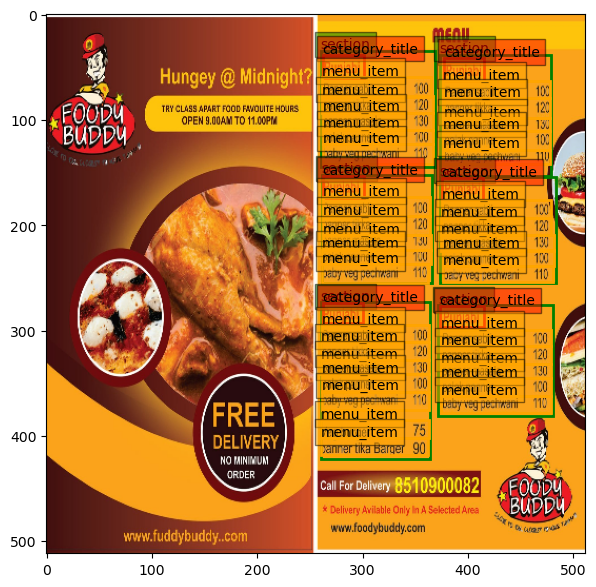

In [6]:
# Helper function to visualize bounding boxes
# It takes an image and a list of bounding boxes as inputs and plots an image with all the bounding boxes
# Each bounding box class should have a different color

color_map = {0: 'red', 1: 'orange', 2: 'green'}

def visualize_bounding_boxes(image, annotations):
    plt.imshow(image)
    ax = plt.gca()

    for annotation in annotations:
        xmin, ymin, xmax, ymax, class_id = annotation.xmin, annotation.ymin, annotation.xmax, annotation.ymax, annotation.class_id

        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color_map[class_id], linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2, label_map[class_id], bbox=dict(facecolor=color_map[class_id], alpha=0.5))


plt.figure(figsize=(7, 7))

visualize_bounding_boxes(images[0], annotations[0])
plt.show()




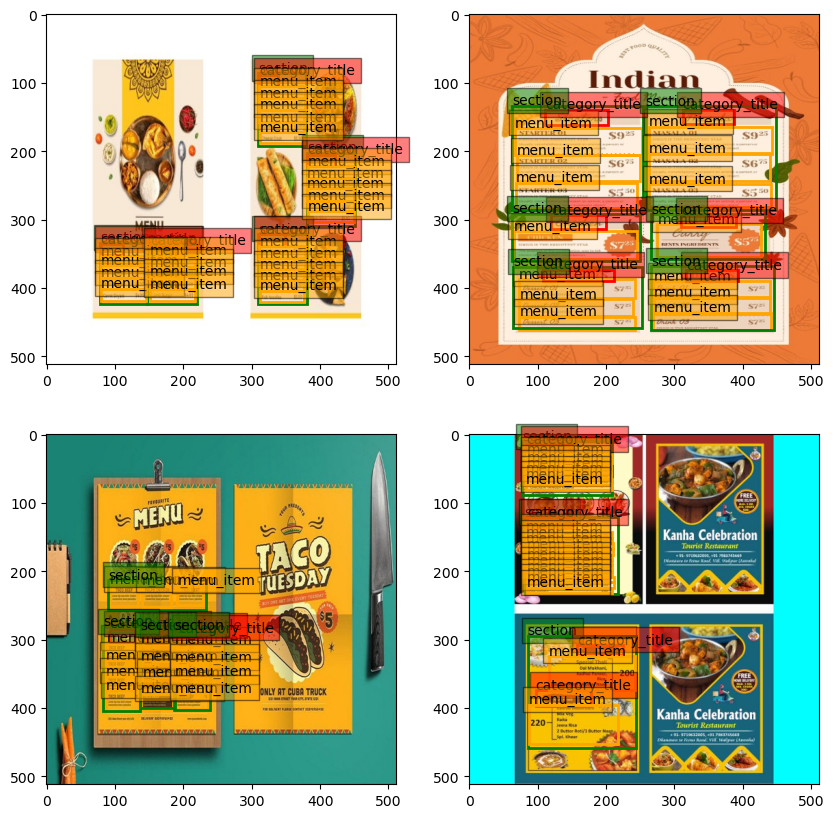

In [7]:
# Draw 4 randim images with bounding boxes in a 2x2 grid
plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    random_index = np.random.randint(len(images))
    visualize_bounding_boxes(images[random_index], annotations[random_index])
plt.show()

In [8]:
def create_dir_or_clean(path):
    os.makedirs(path, exist_ok=True)
    for file in os.listdir(path):
        os.remove(os.path.join(path, file))

def save_images_and_txt_files(images, annotations, image_path, label_path, file_base_name):
    for i, (train_image, train_annotation) in enumerate(zip(images, annotations)):
        image_name = f'{file_base_name}_{i}.jpg'
        label_name = f'{file_base_name}_{i}.txt'

        # Write the image to disk using cv2. Keep in mind that the images are in RGB and cv2 uses BGR by default
        cv2.imwrite(os.path.join(image_path, image_name), cv2.cvtColor(train_image, cv2.COLOR_RGB2BGR))

        with open(os.path.join(label_path, label_name), 'w') as f:
            for annotation in train_annotation:
                f.write(f"{annotation[0]} {annotation[1]} {annotation[2]} {annotation[3]} {annotation[4]}\n")


In [9]:

# THis function has the following responsibilities:
# 1. Convert the annotations into the YOLO format
# 2. Split the data into train and validation sets
# 3. Save the data final_datasdet/images/train, final_datasdet/images/val and final_datasdet/labels/train, final_datasdet/labels/val
# 4. Save the label_map into final_datasdet/labels/darknet.labels
# 5. save the yolo configuration yaml file
def save_for_yolo_training(images, annotations):
    # Convert annotations into YOLO format
    yolo_annotations = []
    for sub_annotations in annotations:
        yolo_annotations.append([])
        for annotation in sub_annotations:
            x_center = (annotation.xmin + annotation.xmax) / 2
            y_center = (annotation.ymin + annotation.ymax) / 2
            width = annotation.xmax - annotation.xmin
            height = annotation.ymax - annotation.ymin

            # Normalize coordinates
            x_center /= input_shape[0]
            y_center /= input_shape[1]
            width /= input_shape[0]
            height /= input_shape[1]

            yolo_annotations[-1].append([annotation.class_id, x_center, y_center, width, height])

    # Split into train and validation sets
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, yolo_annotations, test_size=0.2, shuffle=True, random_state=42)

    # Create the directories
    image_train_path = 'final_dataset/images/train'
    image_val_path = 'final_dataset/images/val'
    label_train_path = 'final_dataset/labels/train'
    label_val_path = 'final_dataset/labels/val'
    create_dir_or_clean(image_train_path)
    create_dir_or_clean(image_val_path)
    create_dir_or_clean(label_train_path)
    create_dir_or_clean(label_val_path)

    # Save the images and labels
    save_images_and_txt_files(train_images, train_annotations, image_train_path, label_train_path, 'train')
    save_images_and_txt_files(val_images, val_annotations, image_val_path, label_val_path, 'val')

    # Copy the darknet.labels file to label train and val paths
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_train_path}')
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_val_path}')

    # Create and save the yolo configuration file
    yolo_config = {
        'path': os.path.abspath('final_dataset'),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(label_map),
        'names': label_map,

    }
    yaml.dump(yolo_config, open('final_dataset/yolo_config.yaml', 'w'))


save_for_yolo_training(images, annotations)


In [20]:
from ultralytics import YOLO
from sklearn.model_selection import ParameterGrid
import uuid
# hyperparameters to search through
learning_rates = [0.001,0.01,0.1,0.5]
batch_sizes = [16,32,64]
epochs = [3,6,9,12]
netw_archs = ["yolov8n","yolov8m","yolov8x"] #"yolov8m" maybe auch
confidences = [0.25,0.5,0.75,1]
nms_thresholds = [0.25,0.5,0,75,1]
# number of filters
# number of layers
# activationfucntions
# list of parameters to experiment with in train/args.yaml

pm_grid_space = {'learning_rate': learning_rates,
                 'batch_size': batch_sizes,
                 'epochs': epochs,
                 'network_architecture': netw_archs,
                 'confidence': confidences}
                 #'NMS_threshold': nms_thresholds}

pm_grid = ParameterGrid(pm_grid_space)

for params in pm_grid:
    name = "train" + str(uuid.uuid4())
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    num_epochs = params['epochs']
    netw_arch = params['network_architecture']
    confidence = params['confidence']
    #nms_thresh = params['NMS_threshold']

    model = YOLO(f"{netw_arch}.yaml").load(f"{netw_arch}.pt") # from local file

    results = model.train(data = "./final_dataset/yolo_config.yaml",lrf = learning_rate, epochs = num_epochs, batch = batch_size, name = name, conf = confidence)
    # Load the model and make predictions on the validation set
    model = YOLO(f"{netw_arch}.yaml").load(f"./runs/detect/{name}/weights/best.pt") # from local file
    image, annotation = images[0], annotations[0]

    # Make predictions on the image
    predictions = model(image)

    predictions[0].boxes


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               


  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /home/lukas/Uni/Fontys/Semester7/DASC2/dasc2-data-challenge-project/Menu_Card_Transformation/final_dataset/labels/train.cache... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]
val: Scanning /home/lukas/Uni/Fontys/Semester7/DASC2/dasc2-data-challenge-project/Menu_Card_Transformation/final_dataset/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]

Plotting labels to runs/detect/train84a41c53-211d-46de-a70e-01c961207440/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train84a41c53-211d-46de-a70e-01c961207440
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      3.068      3.818      2.379        388        640: 100%|██████████| 4/4 [00:21<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]

                   all         15        341          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      2.775      3.754      2.169        492        640: 100%|██████████| 4/4 [00:26<00:00,  6.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]

                   all         15        341          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      2.641      3.641      2.031        323        640: 100%|██████████| 4/4 [00:26<00:00,  6.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]

                   all         15        341          0          0          0          0



3 epochs completed in 0.024 hours.
Optimizer stripped from runs/detect/train84a41c53-211d-46de-a70e-01c961207440/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train84a41c53-211d-46de-a70e-01c961207440/weights/best.pt, 6.2MB

Validating runs/detect/train84a41c53-211d-46de-a70e-01c961207440/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.1+cu121 CPU (Intel Core(TM) i7-1065G7 1.30GHz)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

                   all         15        341          0          0          0          0


Speed: 1.4ms preprocess, 138.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train84a41c53-211d-46de-a70e-01c961207440

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralyt

train: Scanning /home/lukas/Uni/Fontys/Semester7/DASC2/dasc2-data-challenge-project/Menu_Card_Transformation/final_dataset/labels/train.cache... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]
val: Scanning /home/lukas/Uni/Fontys/Semester7/DASC2/dasc2-data-challenge-project/Menu_Card_Transformation/final_dataset/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to runs/detect/trainccc8ee60-911c-4afd-9847-9d7ae63686df/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/trainccc8ee60-911c-4afd-9847-9d7ae63686df
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/4 [00:53<?, ?it/s]


KeyboardInterrupt: 


                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640

FileNotFoundError: [Errno 2] No such file or directory: '../runs/detect/train2/weights/best.pt'